In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from evaluation.prep_datasets import extract_features_not_normalised
from evaluation.evaluate_mimic import evaluate_mimic, evaluate_random
import torch

In [100]:
model_type = 'NN'

In [97]:
class NN_params:
    # learning_rate = 0.01
    # regularisation = 0.01
    # num_layers = 4
    # hidden_layer_sizes = [8,4]
    learning_rate = 0.03
    regularisation = 0.001
    num_layers = 5
    hidden_layer_sizes = [92, 92, 46]
    epochs = 15569

In [98]:
# load weights
with open('..\..\quality_metrics\\1000weights.pkl', 'rb') as f:
    loaded_weights = pkl.load(f)

In [99]:
def load_nn_model(num_features, hidden_layer_sizes, num_layers, path, outputs):
    layers = [num_features*2] + hidden_layer_sizes + [outputs]
    base_model = torch.nn.Sequential()
    base_model.add_module('linear' + str(0), torch.nn.Linear(layers[0], layers[1]))
    for i in range(1, num_layers-2):
        base_model.add_module('relu' + str(i-1), torch.nn.ReLU())
        base_model.add_module('linear' + str(i), torch.nn.Linear(layers[i], layers[i+1]))
    base_model.add_module('relu' + str(num_layers-3), torch.nn.ReLU())
    model_end = torch.nn.Linear(layers[-2], layers[-1])

    model = torch.nn.Sequential(base_model, model_end)
    model.load_state_dict(torch.load(path))
    return model

In [70]:
def load_lm_model(num_features, outputs, path):
    model = torch.nn.Linear(num_features*2, outputs)
    model.load_state_dict(torch.load(path))
    return model

In [101]:
num_features = 46

# numbers from 0 to 29
weights = [i for i in range(1,30)]

models_con = {}
models_sin = {}

# go through folders in 'datasets\weights\step'
for weight in weights:
    models_con[weight] = []
    models_sin[weight] = []
    model_str = '' if model_type == 'NN' else 'linear'
    folder_path = '..\..\datasets\\weights_norm\\mcts_trained\\' + 'weight_'+ str(weight) + '\\results'+model_str+'\800\saved_models'
    for path in os.listdir(folder_path):
        if 'baseline' in path:
            continue
        if 'con' in path:
            if model_type == 'NN':
                model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 1)
            elif model_type == 'linear':
                model = load_lm_model(num_features, 1, os.path.join(folder_path, path))
            models_con[weight].append(model)
        elif 'sin' in path:
            if model_type == 'NN':
                model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 2)
            elif model_type == 'linear':
                model = load_lm_model(num_features, 2, os.path.join(folder_path, path))
            models_sin[weight].append(model)

In [102]:
# load the datasets
test_set_cons = {}
test_set_sins = {}
test_labels_cons = {}
test_labels_sins = {}

for weight in weights:
    # datasets\weights\step\weight_1\data_split_con.pkl
    with open('..\..\datasets\weights_norm\mcts_trained\weight_'+str(weight)+'\data_split_con.pkl', 'rb') as f:
        _, _, test_set_con, test_labels_con = pkl.load(f)
    with open('..\..\datasets\weights_norm\mcts_trained\weight_'+str(weight)+'\data_split_sin.pkl', 'rb') as f:
        _, _, test_set_sin, test_labels_sin = pkl.load(f)
        
    test_set_cons[weight] = test_set_con
    test_set_sins[weight] = test_set_sin
    test_labels_cons[weight] = test_labels_con
    test_labels_sins[weight] = test_labels_sin

# load the whole test set
with open('..\..\datasets\weights_norm\mcts_trained\\baseline\data_split_con.pkl', 'rb') as f:
    _, _, test_set_con_combined, test_labels_con_combined = pkl.load(f)
with open('..\..\datasets\weights_norm\mcts_trained\\baseline\data_split_sin.pkl', 'rb') as f:
    _, _, test_set_sin_combined, test_labels_sin_combined = pkl.load(f)

In [81]:
def test(models, test, labels):
    test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random = [], [], [], [], [], []
    for model in models:
        test_loss, test_mean_error, test_rmse, r2, pearson_correlation, spearman_correlation, pred_label_pairs = evaluate_mimic(model, test, labels, worst=False, best=False, features=['citizens_saved', 'unsaved_citizens', 'distance_to_citizen', 'standing_on_extinguisher', 'length', 'could_have_saved', 'final_number_of_unsaved_citizens', 'moved_towards_closest_citizen'])
        test_losses_random.append(test_loss)
        test_mean_errors_random.append(test_mean_error)
        test_rmses_random.append(test_rmse)
        r2s_random.append(r2)
        pearson_correlations_random.append(pearson_correlation)
        spearman_correlations_random.append(spearman_correlation)

    return test_losses_random, test_mean_errors_random, test_rmses_random, r2s_random, pearson_correlations_random, spearman_correlations_random

In [103]:
test_losses_own_con, test_mean_errors_own_con, test_rmses_own_con, r2s_own_con, pearson_correlations_own_con, spearman_correlations_own_con = {}, {}, {}, {}, {}, {}
test_losses_combined_con, test_mean_errors_combined_con, test_rmses_combined_con, r2s_combined_con, pearson_correlations_combined_con, spearman_correlations_combined_con = {}, {}, {}, {}, {}, {}
test_losses_own_sin, test_mean_errors_own_sin, test_rmses_own_sin, r2s_own_sin, pearson_correlations_own_sin, spearman_correlations_own_sin = {}, {}, {}, {}, {}, {}
test_losses_combined_sin, test_mean_errors_combined_sin, test_rmses_combined_sin, r2s_combined_sin, pearson_correlations_combined_sin, spearman_correlations_combined_sin = {}, {}, {}, {}, {}, {}
pearson_correlations_combined_sincon = {}
for weight in weights:
    test_losses_own_con[weight], test_mean_errors_own_con[weight], test_rmses_own_con[weight], r2s_own_con[weight], pearson_correlations_own_con[weight], spearman_correlations_own_con[weight] = test(models_con[weight], test_set_cons[weight], test_labels_cons[weight])
    test_losses_combined_con[weight], test_mean_errors_combined_con[weight], test_rmses_combined_con[weight], r2s_combined_con[weight], pearson_correlations_combined_con[weight], spearman_correlations_combined_con[weight] = test(models_con[weight], test_set_con_combined, test_labels_con_combined)
    test_losses_own_sin[weight], test_mean_errors_own_sin[weight], test_rmses_own_sin[weight], r2s_own_sin[weight], pearson_correlations_own_sin[weight], spearman_correlations_own_sin[weight] = test(models_sin[weight], test_set_sins[weight], test_labels_sins[weight])
    test_losses_combined_sin[weight], test_mean_errors_combined_sin[weight], test_rmses_combined_sin[weight], r2s_combined_sin[weight], pearson_correlations_combined_sin[weight], spearman_correlations_combined_sin[weight] = test(models_sin[weight], test_set_sin_combined, test_labels_sin_combined)

    pearson_correlations_combined_sincon[weight] = [(pearson_correlations_combined_con[weight][i] + pearson_correlations_combined_sin[weight][i])/2 for i in range(len(pearson_correlations_combined_con[weight]))]

In [96]:
# find the key with the highest pearson_correlations_combined_con
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_con.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key
best_weight_con = loaded_weights[max_key]
print('best weight contrastive:', max_key, best_weight_con)
print(max_value)
worst_weight_con = loaded_weights[min_key]
print('worst weight contrastive:', min_key, worst_weight_con)
print(min_value)

# find the key with the highest pearson_correlations_combined_sin
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_sin.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key
best_weight_sin = loaded_weights[max_key]
print('best weight single:', max_key, best_weight_con)
print(max_value)
worst_weight_sin = loaded_weights[min_key]
print('worst weight single:', min_key, worst_weight_con)
print(min_value)

# find the key with the highest pearson_correlations_combined_sincon
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_sincon.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key

best_weight_sincon = loaded_weights[max_key]
print('best weight single + contrastive:', max_key, best_weight_con)
print(max_value)
worst_weight_sincon = loaded_weights[min_key]
print('worst weight single + contrastive:', min_key, worst_weight_con)
print(min_value)

best weight contrastive: 23 {'validity': 0.9822207623112915, 'proximity': 0.9802214306709599, 'critical_state': 0.5275291954721577, 'diversity': 0.5759550294307381, 'realisticness': 0.3031030345514204, 'sparsity': 0.8514264943878943}
0.5454418078099202
worst weight contrastive: 20 {'validity': 0.0056270520166376015, 'proximity': 0.26724024595642415, 'critical_state': 0.9241870438960845, 'diversity': 0.8909453329313312, 'realisticness': 0.35286434679412615, 'sparsity': 0.5786104105999821}
0.2550129867360125
best weight single: 14 {'validity': 0.9822207623112915, 'proximity': 0.9802214306709599, 'critical_state': 0.5275291954721577, 'diversity': 0.5759550294307381, 'realisticness': 0.3031030345514204, 'sparsity': 0.8514264943878943}
0.586169811980831
worst weight single: 4 {'validity': 0.0056270520166376015, 'proximity': 0.26724024595642415, 'critical_state': 0.9241870438960845, 'diversity': 0.8909453329313312, 'realisticness': 0.35286434679412615, 'sparsity': 0.5786104105999821}
0.27079

In [56]:
table = [
    ['quality criterion', 'best weight contrastive', 'worst weight contrastive', 'best weight single', 'worst weight single'],
    ['validity', round(best_weight_con['validity'],3), round(worst_weight_con['validity'],3), round(best_weight_sin['validity'],3), round(worst_weight_sin['validity'],3)],
    ['proximity', round(best_weight_con['proximity'],3), round(worst_weight_con['proximity'],3), round(best_weight_sin['proximity'],3), round(worst_weight_sin['proximity'],3)],
    ['diverstiy', round(best_weight_con['diversity'],3), round(worst_weight_con['diversity'],3), round(best_weight_sin['diversity'],3), round(worst_weight_sin['diversity'],3)],
    ['state importance', round(best_weight_con['critical_state'],3), round(worst_weight_con['critical_state'],3), round(best_weight_sin['critical_state'],3), round(worst_weight_sin['critical_state'],3)],
    ['realisticness', round(best_weight_con['realisticness'],3), round(worst_weight_con['realisticness'],3), round(best_weight_sin['realisticness'],3), round(worst_weight_sin['realisticness'],3)],
    ['sparsity', round(best_weight_con['sparsity'],3), round(worst_weight_con['sparsity'],3), round(best_weight_sin['sparsity'],3), round(worst_weight_sin['sparsity'],3)],
]

# turn the table 90 degrees
table = np.array(table)
table = table.transpose()

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrrrrr}
\hline
 quality criterion        &   validity &   proximity &   diverstiy &   state importance &   realisticness &   sparsity \\
\hline
 best weight contrastive  &      0.982 &       0.98  &       0.576 &              0.528 &           0.303 &      0.851 \\
 worst weight contrastive &      0.006 &       0.267 &       0.891 &              0.924 &           0.353 &      0.579 \\
 best weight single       &      0.878 &       0.92  &       0.915 &              0.674 &           0.639 &      0.657 \\
 worst weight single      &      0.412 &       0.836 &       0.38  &              0.087 &           0.042 &      0.748 \\
\hline
\end{tabular}


In [36]:
table = [
    ['quality criterion', 'best weight contrastive', 'worst weight contrastive', 'best weight single', 'worst weight single'],
    ['validity', round(best_weight_con['validity'],3), round(worst_weight_con['validity'],3), round(best_weight_sin['validity'],3), round(worst_weight_sin['validity'],3)],
    ['proximity', round(best_weight_con['proximity'],3), round(worst_weight_con['proximity'],3), round(best_weight_sin['proximity'],3), round(worst_weight_sin['proximity'],3)],
    ['diverstiy', round(best_weight_con['diversity'],3), round(worst_weight_con['diversity'],3), round(best_weight_sin['diversity'],3), round(worst_weight_sin['diversity'],3)],
    ['state importance', round(best_weight_con['critical_state'],3), round(worst_weight_con['critical_state'],3), round(best_weight_sin['critical_state'],3), round(worst_weight_sin['critical_state'],3)],
    ['realisticness', round(best_weight_con['realisticness'],3), round(worst_weight_con['realisticness'],3), round(best_weight_sin['realisticness'],3), round(worst_weight_sin['realisticness'],3)],
    ['sparsity', round(best_weight_con['sparsity'],3), round(worst_weight_con['sparsity'],3), round(best_weight_sin['sparsity'],3), round(worst_weight_sin['sparsity'],3)],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrrr}
\hline
 quality criterion   &   best weight contrastive &   worst weight contrastive &   best weight single &   worst weight single \\
\hline
 validity            &                     0.902 &                      0.006 &                0.878 &                 0.412 \\
 proximity           &                     0.658 &                      0.267 &                0.92  &                 0.836 \\
 diverstiy           &                     0.405 &                      0.891 &                0.915 &                 0.38  \\
 state importance    &                     0.587 &                      0.924 &                0.674 &                 0.087 \\
 realisticness       &                     0.12  &                      0.353 &                0.639 &                 0.042 \\
 sparsity            &                     0.988 &                      0.579 &                0.657 &                 0.748 \\
\hline
\end{tabular}


In [65]:
from scipy.stats import pearsonr, spearmanr

# calculate the correlation between the weights and the pearson_correlations_combined_con
weights = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,17,18,19,20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
vals = []
prox = []
divs = []
crits = []
reals = []
spars = []
sums = []
pearson_con = []
pearson_sin = []
for weight in weights:
    pearson_con.append(np.mean(pearson_correlations_combined_con[weight]))
    pearson_sin.append(np.mean(pearson_correlations_combined_sin[weight]))
    vals.append(loaded_weights[weight]['validity'])
    prox.append(loaded_weights[weight]['proximity'])
    divs.append(loaded_weights[weight]['diversity'])
    crits.append(loaded_weights[weight]['critical_state'])
    reals.append(loaded_weights[weight]['realisticness'])
    spars.append(loaded_weights[weight]['sparsity'])
    sums.append(loaded_weights[weight]['validity'] + loaded_weights[weight]['proximity'] + loaded_weights[weight]['diversity'] + loaded_weights[weight]['critical_state'] + loaded_weights[weight]['realisticness'] + loaded_weights[weight]['sparsity'])
    


vals_corr_pear_con, vals_corr_spear_con = pearsonr(pearson_con, vals)[0], spearmanr(pearson_con, vals)[0]
prox_corr_pear_con, prox_corr_spear_con = pearsonr(pearson_con, prox)[0], spearmanr(pearson_con, prox)[0]
divs_corr_pear_con, divs_corr_spear_con = pearsonr(pearson_con, divs)[0], spearmanr(pearson_con, divs)[0]
crits_corr_pear_con, crits_corr_spear_con = pearsonr(pearson_con, crits)[0], spearmanr(pearson_con, crits)[0]
reals_corr_pear_con, reals_corr_spear_con = pearsonr(pearson_con, reals)[0], spearmanr(pearson_con, reals)[0]
spars_corr_pear_con, spars_corr_spear_con = pearsonr(pearson_con, spars)[0], spearmanr(pearson_con, spars)[0]
sums_corr_pear_con, sums_corr_spear_con = pearsonr(pearson_con, sums)[0], spearmanr(pearson_con, sums)[0]

vals_corr_pear_sin, vals_corr_spear_sin = pearsonr(pearson_sin, vals)[0], spearmanr(pearson_sin, vals)[0]
prox_corr_pear_sin, prox_corr_spear_sin = pearsonr(pearson_sin, prox)[0], spearmanr(pearson_sin, prox)[0]
divs_corr_pear_sin, divs_corr_spear_sin = pearsonr(pearson_sin, divs)[0], spearmanr(pearson_sin, divs)[0]
crits_corr_pear_sin, crits_corr_spear_sin = pearsonr(pearson_sin, crits)[0], spearmanr(pearson_sin, crits)[0]
reals_corr_pear_sin, reals_corr_spear_sin = pearsonr(pearson_sin, reals)[0], spearmanr(pearson_sin, reals)[0]
spars_corr_pear_sin, spars_corr_spear_sin = pearsonr(pearson_sin, spars)[0], spearmanr(pearson_sin, spars)[0]
sums_corr_pear_sin, sums_corr_spear_sin = pearsonr(pearson_sin, sums)[0], spearmanr(pearson_sin, sums)[0]

table_spear = [
    ['Criterion'] + ['Pearson Con'] + ['Spearman Con'] + ['Pearson Sin'] + ['Spearman Sin'],
    ['Validity'] + [vals_corr_pear_con] + [vals_corr_spear_con] + [vals_corr_pear_sin] + [vals_corr_spear_sin],
    ['Proximity'] + [prox_corr_pear_con] + [prox_corr_spear_con] + [prox_corr_pear_sin] + [prox_corr_spear_sin],
    ['Diversity'] + [divs_corr_pear_con] + [divs_corr_spear_con] + [divs_corr_pear_sin] + [divs_corr_spear_sin],
    ['Criticality'] + [crits_corr_pear_con] + [crits_corr_spear_con] + [crits_corr_pear_sin] + [crits_corr_spear_sin],
    ['Reality'] + [reals_corr_pear_con] + [reals_corr_spear_con] + [reals_corr_pear_sin] + [reals_corr_spear_sin],
    ['Sparsity'] + [spars_corr_pear_con] + [spars_corr_spear_con] + [spars_corr_pear_sin] + [spars_corr_spear_sin],
    ['Sum'] + [sums_corr_pear_con] + [sums_corr_spear_con] + [sums_corr_pear_sin] + [sums_corr_spear_sin],
]

print(tabulate(table_spear, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═══════════════╤════════════════╤═══════════════╤════════════════╕
│ Criterion   │   Pearson Con │   Spearman Con │   Pearson Sin │   Spearman Sin │
╞═════════════╪═══════════════╪════════════════╪═══════════════╪════════════════╡
│ Validity    │     0.456939  │      0.389499  │    0.321456   │       0.283883 │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Proximity   │     0.260838  │      0.218559  │    0.00908579 │       0.02442  │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Diversity   │     0.30597   │      0.285714  │    0.173403   │       0.148962 │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Criticality │    -0.326665  │     -0.368132  │   -0.35298    │      -0.34188  │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Reality     │    -0.293216  │     -0.347985  │   -0.358496   │      -0.462759 │
├─────────────┼─

In [104]:
from scipy.stats import pearsonr, spearmanr

# calculate the correlation between the weights and the pearson_correlations_combined_con

vals_corr_spear_cons, prox_corr_spear_cons, divs_corr_spear_cons, crits_corr_spear_cons, reals_corr_spear_cons, spars_corr_spear_cons = [], [], [], [], [], []
vals_corr_spear_sins, prox_corr_spear_sins, divs_corr_spear_sins, crits_corr_spear_sins, reals_corr_spear_sins, spars_corr_spear_sins = [], [], [], [], [], []

weights = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
for i in range(10):
    vals = []
    prox = []
    divs = []
    crits = []
    reals = []
    spars = []
    pearson_con = []
    pearson_sin = []
    for weight in weights:
        pearson_con.append(np.mean(pearson_correlations_combined_con[weight][i]))
        pearson_sin.append(np.mean(pearson_correlations_combined_sin[weight][i]))
        vals.append(loaded_weights[weight]['validity'])
        prox.append(loaded_weights[weight]['proximity'])
        divs.append(loaded_weights[weight]['diversity'])
        crits.append(loaded_weights[weight]['critical_state'])
        reals.append(loaded_weights[weight]['realisticness'])
        spars.append(loaded_weights[weight]['sparsity'])
        


    vals_corr_pear_con, vals_corr_spear_con = pearsonr(pearson_con, vals)[0], spearmanr(pearson_con, vals)[0]
    prox_corr_pear_con, prox_corr_spear_con = pearsonr(pearson_con, prox)[0], spearmanr(pearson_con, prox)[0]
    divs_corr_pear_con, divs_corr_spear_con = pearsonr(pearson_con, divs)[0], spearmanr(pearson_con, divs)[0]
    crits_corr_pear_con, crits_corr_spear_con = pearsonr(pearson_con, crits)[0], spearmanr(pearson_con, crits)[0]
    reals_corr_pear_con, reals_corr_spear_con = pearsonr(pearson_con, reals)[0], spearmanr(pearson_con, reals)[0]
    spars_corr_pear_con, spars_corr_spear_con = pearsonr(pearson_con, spars)[0], spearmanr(pearson_con, spars)[0]

    vals_corr_pear_sin, vals_corr_spear_sin = pearsonr(pearson_sin, vals)[0], spearmanr(pearson_sin, vals)[0]
    prox_corr_pear_sin, prox_corr_spear_sin = pearsonr(pearson_sin, prox)[0], spearmanr(pearson_sin, prox)[0]
    divs_corr_pear_sin, divs_corr_spear_sin = pearsonr(pearson_sin, divs)[0], spearmanr(pearson_sin, divs)[0]
    crits_corr_pear_sin, crits_corr_spear_sin = pearsonr(pearson_sin, crits)[0], spearmanr(pearson_sin, crits)[0]
    reals_corr_pear_sin, reals_corr_spear_sin = pearsonr(pearson_sin, reals)[0], spearmanr(pearson_sin, reals)[0]
    spars_corr_pear_sin, spars_corr_spear_sin = pearsonr(pearson_sin, spars)[0], spearmanr(pearson_sin, spars)[0]

    vals_corr_spear_cons.append(vals_corr_spear_con)
    prox_corr_spear_cons.append(prox_corr_spear_con)
    divs_corr_spear_cons.append(divs_corr_spear_con)
    crits_corr_spear_cons.append(crits_corr_spear_con)
    reals_corr_spear_cons.append(reals_corr_spear_con)
    spars_corr_spear_cons.append(spars_corr_spear_con)
    
    vals_corr_spear_sins.append(vals_corr_spear_sin)
    prox_corr_spear_sins.append(prox_corr_spear_sin)
    divs_corr_spear_sins.append(divs_corr_spear_sin)
    crits_corr_spear_sins.append(crits_corr_spear_sin)
    reals_corr_spear_sins.append(reals_corr_spear_sin)
    spars_corr_spear_sins.append(spars_corr_spear_sin)

# calculate std
vals_corr_spear_cons_std = np.std(vals_corr_spear_cons)
prox_corr_spear_cons_std = np.std(prox_corr_spear_cons)
divs_corr_spear_cons_std = np.std(divs_corr_spear_cons)
crits_corr_spear_cons_std = np.std(crits_corr_spear_cons)
reals_corr_spear_cons_std = np.std(reals_corr_spear_cons)
spars_corr_spear_cons_std = np.std(spars_corr_spear_cons)

vals_corr_spear_sins_std = np.std(vals_corr_spear_sins)
prox_corr_spear_sins_std = np.std(prox_corr_spear_sins)
divs_corr_spear_sins_std = np.std(divs_corr_spear_sins)
crits_corr_spear_sins_std = np.std(crits_corr_spear_sins)
reals_corr_spear_sins_std = np.std(reals_corr_spear_sins)
spars_corr_spear_sins_std = np.std(spars_corr_spear_sins)


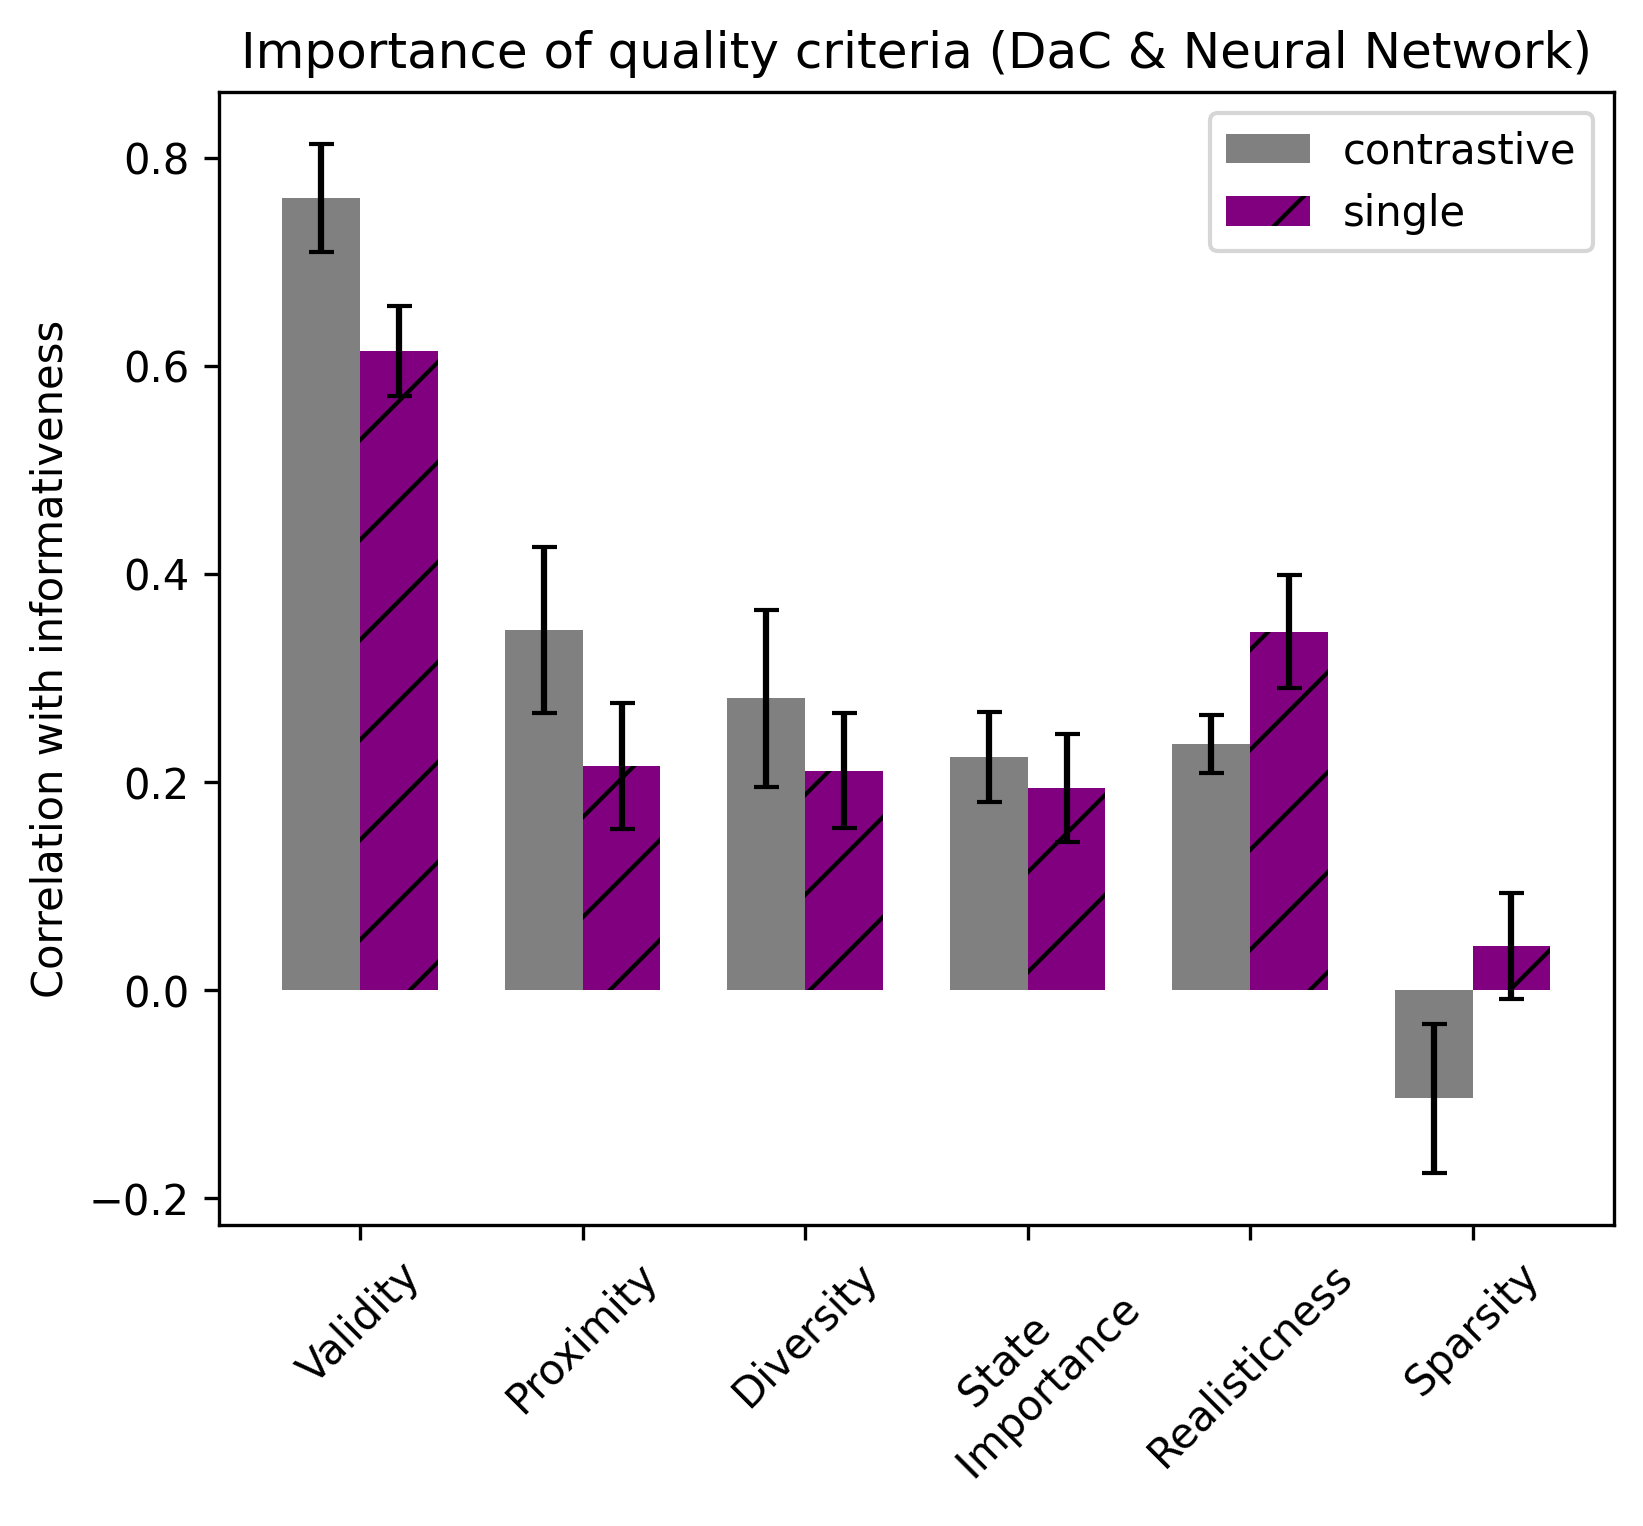

In [105]:
# barplot with spearman correaltions
plt.figure(figsize=(6, 5), dpi=300)
x_labels = ['Validity', 'Proximity', 'Diversity', 'State \n Importance', 'Realisticness', 'Sparsity']
y_con = [vals_corr_spear_con, prox_corr_spear_con, divs_corr_spear_con, crits_corr_spear_con, reals_corr_spear_con, spars_corr_spear_con]
y_sin = [vals_corr_spear_sin, prox_corr_spear_sin, divs_corr_spear_sin, crits_corr_spear_sin, reals_corr_spear_sin, spars_corr_spear_sin]
y_con_std = [vals_corr_spear_cons_std, prox_corr_spear_cons_std, divs_corr_spear_cons_std, crits_corr_spear_cons_std, reals_corr_spear_cons_std, spars_corr_spear_cons_std]
y_sin_std = [vals_corr_spear_sins_std, prox_corr_spear_sins_std, divs_corr_spear_sins_std, crits_corr_spear_sins_std, reals_corr_spear_sins_std, spars_corr_spear_sins_std]

bar_width = 0.35
x = np.arange(len(x_labels))  # the label locations

bar1 = plt.bar(x - bar_width/2, y_con, bar_width, yerr=y_con_std, capsize=3, label='contrastive', color='grey')
bar2 = plt.bar(x + bar_width/2, y_sin, bar_width, yerr=y_sin_std, capsize=3, label='single', color='purple', hatch='/')
# include standard deviation

# bar1.set_hetch('/')

plt.ylabel('Correlation with informativeness')
plt.xticks(x, x_labels, rotation=45)
plt.legend()
plt.title('Importance of quality criteria (DaC & Neural Network)')
# plt.tight_layout()
plt.savefig('importance-weights-NN-dac.pdf', format='pdf', bbox_inches='tight')

### Interpretation

For Contrastive Learning: 
- High weights on Validity and Realisticness have the most influence on the learning
- Diversity seems counterproductive

For Single Learning:
- Criticality, Realisticness, Sparsity and Validity are important
- Diversity is still counterproductive
    - It is unclear whether Diversity in itself is actually bad or in how it interacts with the other criteria

It's slightly surprising that proximity is not that helpful.
For both tasks Validity and Realisticness are important, while State importance and Sparsity are mostly relevant for the single learning.

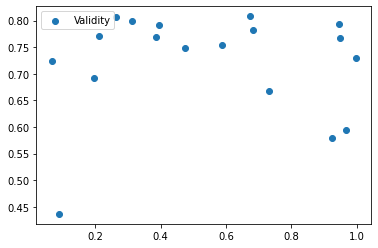

In [14]:
# Scatter plot for data

slope, intercept = np.polyfit(crits, pearson_sin, 1)

plt.scatter(crits, pearson_sin, label='Validity')
# line_x = np.linspace(min(crits), max(crits), 100)  #100 evenly spaced points
# line_y = slope * line_x + intercept
# plt.plot(line_x, line_y, color='blue', label='Fit')  # add line to plot
# plt.scatter(prox, pearson_con, label='Proximity')
plt.legend()
plt.show()

In [15]:
table = [
    ["weight", "Pearson Con", "Pearson Sin"]
]
for weight in weights:
    table.append([weight, np.mean(pearson_correlations_combined_con[weight]), np.mean(pearson_correlations_combined_sin[weight])])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════╤═══════════════╕
│   weight │   Pearson Con │   Pearson Sin │
╞══════════╪═══════════════╪═══════════════╡
│        1 │      0.743022 │      0.714796 │
├──────────┼───────────────┼───────────────┤
│        2 │      0.484888 │      0.576866 │
├──────────┼───────────────┼───────────────┤
│        3 │      0.802794 │      0.798641 │
├──────────┼───────────────┼───────────────┤
│        4 │      0.630345 │      0.475286 │
├──────────┼───────────────┼───────────────┤
│        6 │      0.805091 │      0.749429 │
├──────────┼───────────────┼───────────────┤
│        7 │      0.686342 │      0.74023  │
├──────────┼───────────────┼───────────────┤
│        8 │      0.708983 │      0.74883  │
├──────────┼───────────────┼───────────────┤
│        9 │      0.796944 │      0.790321 │
├──────────┼───────────────┼───────────────┤
│       11 │      0.739393 │      0.79248  │
├──────────┼───────────────┼───────────────┤
│       12 │      0.614479 │      0.68935  │
├─────────

# MCTS

In [59]:
class NN_params:
    learning_rate = 0.03
    regularisation = 0.001
    num_layers = 5
    hidden_layer_sizes = [92, 92, 46]
    epochs = 4490

In [60]:
num_features = 46

# numbers from 0 to 29
weights = [i for i in range(1,30)]

models_con = {}
models_sin = {}

# go through folders in 'datasets\weights\step'
for weight in weights:
    models_con[weight] = []
    models_sin[weight] = []
    folder_path = '..\..\datasets\\weights_norm\\mcts_trained\\' + 'weight_'+ str(weight) + '\\results\800\saved_models'
    for path in os.listdir(folder_path):
        if 'baseline' in path:
            continue
        if 'con' in path:
            model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 1)
            models_con[weight].append(model)
        elif 'sin' in path:
            model = load_nn_model(num_features, NN_params.hidden_layer_sizes, NN_params.num_layers, os.path.join(folder_path, path), 2)
            models_sin[weight].append(model)

In [61]:
# load the datasets
test_set_cons = {}
test_set_sins = {}
test_labels_cons = {}
test_labels_sins = {}

for weight in weights:
    # datasets\weights\step\weight_1\data_split_con.pkl
    with open('..\..\datasets\weights_norm\mcts_trained\weight_'+str(weight)+'\data_split_con.pkl', 'rb') as f:
        _, _, test_set_con, test_labels_con = pkl.load(f)
    with open('..\..\datasets\weights_norm\mcts_trained\weight_'+str(weight)+'\data_split_sin.pkl', 'rb') as f:
        
        _, _, test_set_sin, test_labels_sin = pkl.load(f)
    test_set_cons[weight] = test_set_con
    test_set_sins[weight] = test_set_sin
    test_labels_cons[weight] = test_labels_con
    test_labels_sins[weight] = test_labels_sin

# load the whole test set
with open('..\..\datasets\weights_norm\mcts_trained\\baseline\data_split_con.pkl', 'rb') as f:
    _, _, test_set_con_combined, test_labels_con_combined = pkl.load(f)
with open('..\..\datasets\weights_norm\mcts_trained\\baseline\data_split_sin.pkl', 'rb') as f:
    _, _, test_set_sin_combined, test_labels_sin_combined = pkl.load(f)

In [62]:
test_losses_own_con, test_mean_errors_own_con, test_rmses_own_con, r2s_own_con, pearson_correlations_own_con, spearman_correlations_own_con = {}, {}, {}, {}, {}, {}
test_losses_combined_con, test_mean_errors_combined_con, test_rmses_combined_con, r2s_combined_con, pearson_correlations_combined_con, spearman_correlations_combined_con = {}, {}, {}, {}, {}, {}
test_losses_own_sin, test_mean_errors_own_sin, test_rmses_own_sin, r2s_own_sin, pearson_correlations_own_sin, spearman_correlations_own_sin = {}, {}, {}, {}, {}, {}
test_losses_combined_sin, test_mean_errors_combined_sin, test_rmses_combined_sin, r2s_combined_sin, pearson_correlations_combined_sin, spearman_correlations_combined_sin = {}, {}, {}, {}, {}, {}
pearson_correlations_combined_sincon = {}
for weight in weights:
    test_losses_own_con[weight], test_mean_errors_own_con[weight], test_rmses_own_con[weight], r2s_own_con[weight], pearson_correlations_own_con[weight], spearman_correlations_own_con[weight] = test(models_con[weight], test_set_cons[weight], test_labels_cons[weight])
    test_losses_combined_con[weight], test_mean_errors_combined_con[weight], test_rmses_combined_con[weight], r2s_combined_con[weight], pearson_correlations_combined_con[weight], spearman_correlations_combined_con[weight] = test(models_con[weight], test_set_con_combined, test_labels_con_combined)
    test_losses_own_sin[weight], test_mean_errors_own_sin[weight], test_rmses_own_sin[weight], r2s_own_sin[weight], pearson_correlations_own_sin[weight], spearman_correlations_own_sin[weight] = test(models_sin[weight], test_set_sins[weight], test_labels_sins[weight])
    test_losses_combined_sin[weight], test_mean_errors_combined_sin[weight], test_rmses_combined_sin[weight], r2s_combined_sin[weight], pearson_correlations_combined_sin[weight], spearman_correlations_combined_sin[weight] = test(models_sin[weight], test_set_sin_combined, test_labels_sin_combined)

    pearson_correlations_combined_sincon[weight] = [(pearson_correlations_combined_con[weight][i] + pearson_correlations_combined_sin[weight][i])/2 for i in range(len(pearson_correlations_combined_con[weight]))]

In [63]:
# find the key with the highest pearson_correlations_combined_con
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_con.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key
best_weight_con = loaded_weights[max_key]
print('best weight contrastive:', max_key, best_weight_con)
print(max_value)
worst_weight_con = loaded_weights[min_key]
print('worst weight contrastive:', min_key, worst_weight_con)
print(min_value)

# find the key with the highest pearson_correlations_combined_sin
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_sin.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key
best_weight_sin = loaded_weights[max_key]
print('best weight single:', max_key, best_weight_con)
print(max_value)
worst_weight_sin = loaded_weights[min_key]
print('worst weight single:', min_key, worst_weight_con)
print(min_value)

# find the key with the highest pearson_correlations_combined_sincon
max_key = 0
max_value = 0
min_key = 0
min_value = 1
for key, value in pearson_correlations_combined_sincon.items():
    # take the average of value
    value_avg = np.mean(value)
    if value_avg > max_value:
        max_value = value_avg
        max_key = key
    if value_avg < min_value:
        min_value = value_avg
        min_key = key

best_weight_sincon = loaded_weights[max_key]
print('best weight single + contrastive:', max_key, best_weight_con)
print(max_value)
worst_weight_sincon = loaded_weights[min_key]
print('worst weight single + contrastive:', min_key, worst_weight_con)
print(min_value)

best weight contrastive: 23 {'validity': 0.9822207623112915, 'proximity': 0.9802214306709599, 'critical_state': 0.5275291954721577, 'diversity': 0.5759550294307381, 'realisticness': 0.3031030345514204, 'sparsity': 0.8514264943878943}
0.746415216548358
worst weight contrastive: 5 {'validity': 0.12615340095483563, 'proximity': 0.21279164208448842, 'critical_state': 0.9429231450956574, 'diversity': 0.49206652590597066, 'realisticness': 0.05234597184917, 'sparsity': 0.7518368157180263}
0.2972609362009202
best weight single: 14 {'validity': 0.9822207623112915, 'proximity': 0.9802214306709599, 'critical_state': 0.5275291954721577, 'diversity': 0.5759550294307381, 'realisticness': 0.3031030345514204, 'sparsity': 0.8514264943878943}
0.7059780682451725
worst weight single: 2 {'validity': 0.12615340095483563, 'proximity': 0.21279164208448842, 'critical_state': 0.9429231450956574, 'diversity': 0.49206652590597066, 'realisticness': 0.05234597184917, 'sparsity': 0.7518368157180263}
0.26307646066125

In [49]:
table = [
    ['quality criterion', 'best weight contrastive', 'worst weight contrastive', 'best weight single', 'worst weight single'],
    ['validity', round(best_weight_con['validity'],3), round(worst_weight_con['validity'],3), round(best_weight_sin['validity'],3), round(worst_weight_sin['validity'],3)],
    ['proximity', round(best_weight_con['proximity'],3), round(worst_weight_con['proximity'],3), round(best_weight_sin['proximity'],3), round(worst_weight_sin['proximity'],3)],
    ['diverstiy', round(best_weight_con['diversity'],3), round(worst_weight_con['diversity'],3), round(best_weight_sin['diversity'],3), round(worst_weight_sin['diversity'],3)],
    ['state importance', round(best_weight_con['critical_state'],3), round(worst_weight_con['critical_state'],3), round(best_weight_sin['critical_state'],3), round(worst_weight_sin['critical_state'],3)],
    ['realisticness', round(best_weight_con['realisticness'],3), round(worst_weight_con['realisticness'],3), round(best_weight_sin['realisticness'],3), round(worst_weight_sin['realisticness'],3)],
    ['sparsity', round(best_weight_con['sparsity'],3), round(worst_weight_con['sparsity'],3), round(best_weight_sin['sparsity'],3), round(worst_weight_sin['sparsity'],3)],
]

# turn the table 90 degrees
table = np.array(table)
table = table.transpose()

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lrrrrrr}
\hline
 quality criterion        &   validity &   proximity &   diverstiy &   state importance &   realisticness &   sparsity \\
\hline
 best weight contrastive  &      0.982 &       0.98  &       0.576 &              0.528 &           0.303 &      0.851 \\
 worst weight contrastive &      0.126 &       0.213 &       0.492 &              0.943 &           0.052 &      0.752 \\
 best weight single       &      0.878 &       0.92  &       0.915 &              0.674 &           0.639 &      0.657 \\
 worst weight single      &      0.17  &       0.496 &       0.205 &              0.968 &           0.203 &      0.633 \\
\hline
\end{tabular}


In [46]:
from scipy.stats import pearsonr, spearmanr

# calculate the correlation between the weights and the pearson_correlations_combined_con
weights = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,17,18,19,20]
vals = []
prox = []
divs = []
crits = []
reals = []
spars = []
sums = []
pearson_con = []
pearson_sin = []
for weight in weights:
    pearson_con.append(np.mean(pearson_correlations_combined_con[weight]))
    pearson_sin.append(np.mean(pearson_correlations_combined_sin[weight]))
    vals.append(loaded_weights[weight]['validity'])
    prox.append(loaded_weights[weight]['proximity'])
    divs.append(loaded_weights[weight]['diversity'])
    crits.append(loaded_weights[weight]['critical_state'])
    reals.append(loaded_weights[weight]['realisticness'])
    spars.append(loaded_weights[weight]['sparsity'])
    sums.append(loaded_weights[weight]['validity'] + loaded_weights[weight]['proximity'] + loaded_weights[weight]['diversity'] + loaded_weights[weight]['critical_state'] + loaded_weights[weight]['realisticness'] + loaded_weights[weight]['sparsity'])
    


vals_corr_pear_con, vals_corr_spear_con = pearsonr(pearson_con, vals)[0], spearmanr(pearson_con, vals)[0]
prox_corr_pear_con, prox_corr_spear_con = pearsonr(pearson_con, prox)[0], spearmanr(pearson_con, prox)[0]
divs_corr_pear_con, divs_corr_spear_con = pearsonr(pearson_con, divs)[0], spearmanr(pearson_con, divs)[0]
crits_corr_pear_con, crits_corr_spear_con = pearsonr(pearson_con, crits)[0], spearmanr(pearson_con, crits)[0]
reals_corr_pear_con, reals_corr_spear_con = pearsonr(pearson_con, reals)[0], spearmanr(pearson_con, reals)[0]
spars_corr_pear_con, spars_corr_spear_con = pearsonr(pearson_con, spars)[0], spearmanr(pearson_con, spars)[0]
sums_corr_pear_con, sums_corr_spear_con = pearsonr(pearson_con, sums)[0], spearmanr(pearson_con, sums)[0]

vals_corr_pear_sin, vals_corr_spear_sin = pearsonr(pearson_sin, vals)[0], spearmanr(pearson_sin, vals)[0]
prox_corr_pear_sin, prox_corr_spear_sin = pearsonr(pearson_sin, prox)[0], spearmanr(pearson_sin, prox)[0]
divs_corr_pear_sin, divs_corr_spear_sin = pearsonr(pearson_sin, divs)[0], spearmanr(pearson_sin, divs)[0]
crits_corr_pear_sin, crits_corr_spear_sin = pearsonr(pearson_sin, crits)[0], spearmanr(pearson_sin, crits)[0]
reals_corr_pear_sin, reals_corr_spear_sin = pearsonr(pearson_sin, reals)[0], spearmanr(pearson_sin, reals)[0]
spars_corr_pear_sin, spars_corr_spear_sin = pearsonr(pearson_sin, spars)[0], spearmanr(pearson_sin, spars)[0]
sums_corr_pear_sin, sums_corr_spear_sin = pearsonr(pearson_sin, sums)[0], spearmanr(pearson_sin, sums)[0]

table_spear = [
    ['Criterion'] + ['Pearson Con'] + ['Spearman Con'] + ['Pearson Sin'] + ['Spearman Sin'],
    ['Validity'] + [vals_corr_pear_con] + [vals_corr_spear_con] + [vals_corr_pear_sin] + [vals_corr_spear_sin],
    ['Proximity'] + [prox_corr_pear_con] + [prox_corr_spear_con] + [prox_corr_pear_sin] + [prox_corr_spear_sin],
    ['Diversity'] + [divs_corr_pear_con] + [divs_corr_spear_con] + [divs_corr_pear_sin] + [divs_corr_spear_sin],
    ['Criticality'] + [crits_corr_pear_con] + [crits_corr_spear_con] + [crits_corr_pear_sin] + [crits_corr_spear_sin],
    ['Reality'] + [reals_corr_pear_con] + [reals_corr_spear_con] + [reals_corr_pear_sin] + [reals_corr_spear_sin],
    ['Sparsity'] + [spars_corr_pear_con] + [spars_corr_spear_con] + [spars_corr_pear_sin] + [spars_corr_spear_sin],
    ['Sum'] + [sums_corr_pear_con] + [sums_corr_spear_con] + [sums_corr_pear_sin] + [sums_corr_spear_sin],
]

print(tabulate(table_spear, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═══════════════╤════════════════╤═══════════════╤════════════════╕
│ Criterion   │   Pearson Con │   Spearman Con │   Pearson Sin │   Spearman Sin │
╞═════════════╪═══════════════╪════════════════╪═══════════════╪════════════════╡
│ Validity    │      0.861249 │      0.812178  │     0.818053  │      0.690402  │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Proximity   │      0.262797 │      0.20743   │     0.22465   │      0.244582  │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Diversity   │     -0.073326 │      0.0319917 │     0.094574  │      0.22807   │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Criticality │     -0.16923  │      0.124871  │    -0.204709  │      0.112487  │
├─────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ Reality     │      0.32222  │      0.44066   │     0.385026  │      0.448916  │
├─────────────┼─

In [47]:
from scipy.stats import pearsonr, spearmanr

# calculate the correlation between the weights and the pearson_correlations_combined_con

vals_corr_spear_cons, prox_corr_spear_cons, divs_corr_spear_cons, crits_corr_spear_cons, reals_corr_spear_cons, spars_corr_spear_cons = [], [], [], [], [], []
vals_corr_spear_sins, prox_corr_spear_sins, divs_corr_spear_sins, crits_corr_spear_sins, reals_corr_spear_sins, spars_corr_spear_sins = [], [], [], [], [], []

weights = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,17,18,19,20]
for i in range(10):
    vals = []
    prox = []
    divs = []
    crits = []
    reals = []
    spars = []
    pearson_con = []
    pearson_sin = []
    for weight in weights:
        pearson_con.append(np.mean(pearson_correlations_combined_con[weight][i]))
        pearson_sin.append(np.mean(pearson_correlations_combined_sin[weight][i]))
        vals.append(loaded_weights[weight]['validity'])
        prox.append(loaded_weights[weight]['proximity'])
        divs.append(loaded_weights[weight]['diversity'])
        crits.append(loaded_weights[weight]['critical_state'])
        reals.append(loaded_weights[weight]['realisticness'])
        spars.append(loaded_weights[weight]['sparsity'])
        


    vals_corr_pear_con, vals_corr_spear_con = pearsonr(pearson_con, vals)[0], spearmanr(pearson_con, vals)[0]
    prox_corr_pear_con, prox_corr_spear_con = pearsonr(pearson_con, prox)[0], spearmanr(pearson_con, prox)[0]
    divs_corr_pear_con, divs_corr_spear_con = pearsonr(pearson_con, divs)[0], spearmanr(pearson_con, divs)[0]
    crits_corr_pear_con, crits_corr_spear_con = pearsonr(pearson_con, crits)[0], spearmanr(pearson_con, crits)[0]
    reals_corr_pear_con, reals_corr_spear_con = pearsonr(pearson_con, reals)[0], spearmanr(pearson_con, reals)[0]
    spars_corr_pear_con, spars_corr_spear_con = pearsonr(pearson_con, spars)[0], spearmanr(pearson_con, spars)[0]

    vals_corr_pear_sin, vals_corr_spear_sin = pearsonr(pearson_sin, vals)[0], spearmanr(pearson_sin, vals)[0]
    prox_corr_pear_sin, prox_corr_spear_sin = pearsonr(pearson_sin, prox)[0], spearmanr(pearson_sin, prox)[0]
    divs_corr_pear_sin, divs_corr_spear_sin = pearsonr(pearson_sin, divs)[0], spearmanr(pearson_sin, divs)[0]
    crits_corr_pear_sin, crits_corr_spear_sin = pearsonr(pearson_sin, crits)[0], spearmanr(pearson_sin, crits)[0]
    reals_corr_pear_sin, reals_corr_spear_sin = pearsonr(pearson_sin, reals)[0], spearmanr(pearson_sin, reals)[0]
    spars_corr_pear_sin, spars_corr_spear_sin = pearsonr(pearson_sin, spars)[0], spearmanr(pearson_sin, spars)[0]

    vals_corr_spear_cons.append(vals_corr_spear_con)
    prox_corr_spear_cons.append(prox_corr_spear_con)
    divs_corr_spear_cons.append(divs_corr_spear_con)
    crits_corr_spear_cons.append(crits_corr_spear_con)
    reals_corr_spear_cons.append(reals_corr_spear_con)
    spars_corr_spear_cons.append(spars_corr_spear_con)
    
    vals_corr_spear_sins.append(vals_corr_spear_sin)
    prox_corr_spear_sins.append(prox_corr_spear_sin)
    divs_corr_spear_sins.append(divs_corr_spear_sin)
    crits_corr_spear_sins.append(crits_corr_spear_sin)
    reals_corr_spear_sins.append(reals_corr_spear_sin)
    spars_corr_spear_sins.append(spars_corr_spear_sin)

# calculate std
vals_corr_spear_cons_std = np.std(vals_corr_spear_cons)
prox_corr_spear_cons_std = np.std(prox_corr_spear_cons)
divs_corr_spear_cons_std = np.std(divs_corr_spear_cons)
crits_corr_spear_cons_std = np.std(crits_corr_spear_cons)
reals_corr_spear_cons_std = np.std(reals_corr_spear_cons)
spars_corr_spear_cons_std = np.std(spars_corr_spear_cons)

vals_corr_spear_sins_std = np.std(vals_corr_spear_sins)
prox_corr_spear_sins_std = np.std(prox_corr_spear_sins)
divs_corr_spear_sins_std = np.std(divs_corr_spear_sins)
crits_corr_spear_sins_std = np.std(crits_corr_spear_sins)
reals_corr_spear_sins_std = np.std(reals_corr_spear_sins)
spars_corr_spear_sins_std = np.std(spars_corr_spear_sins)


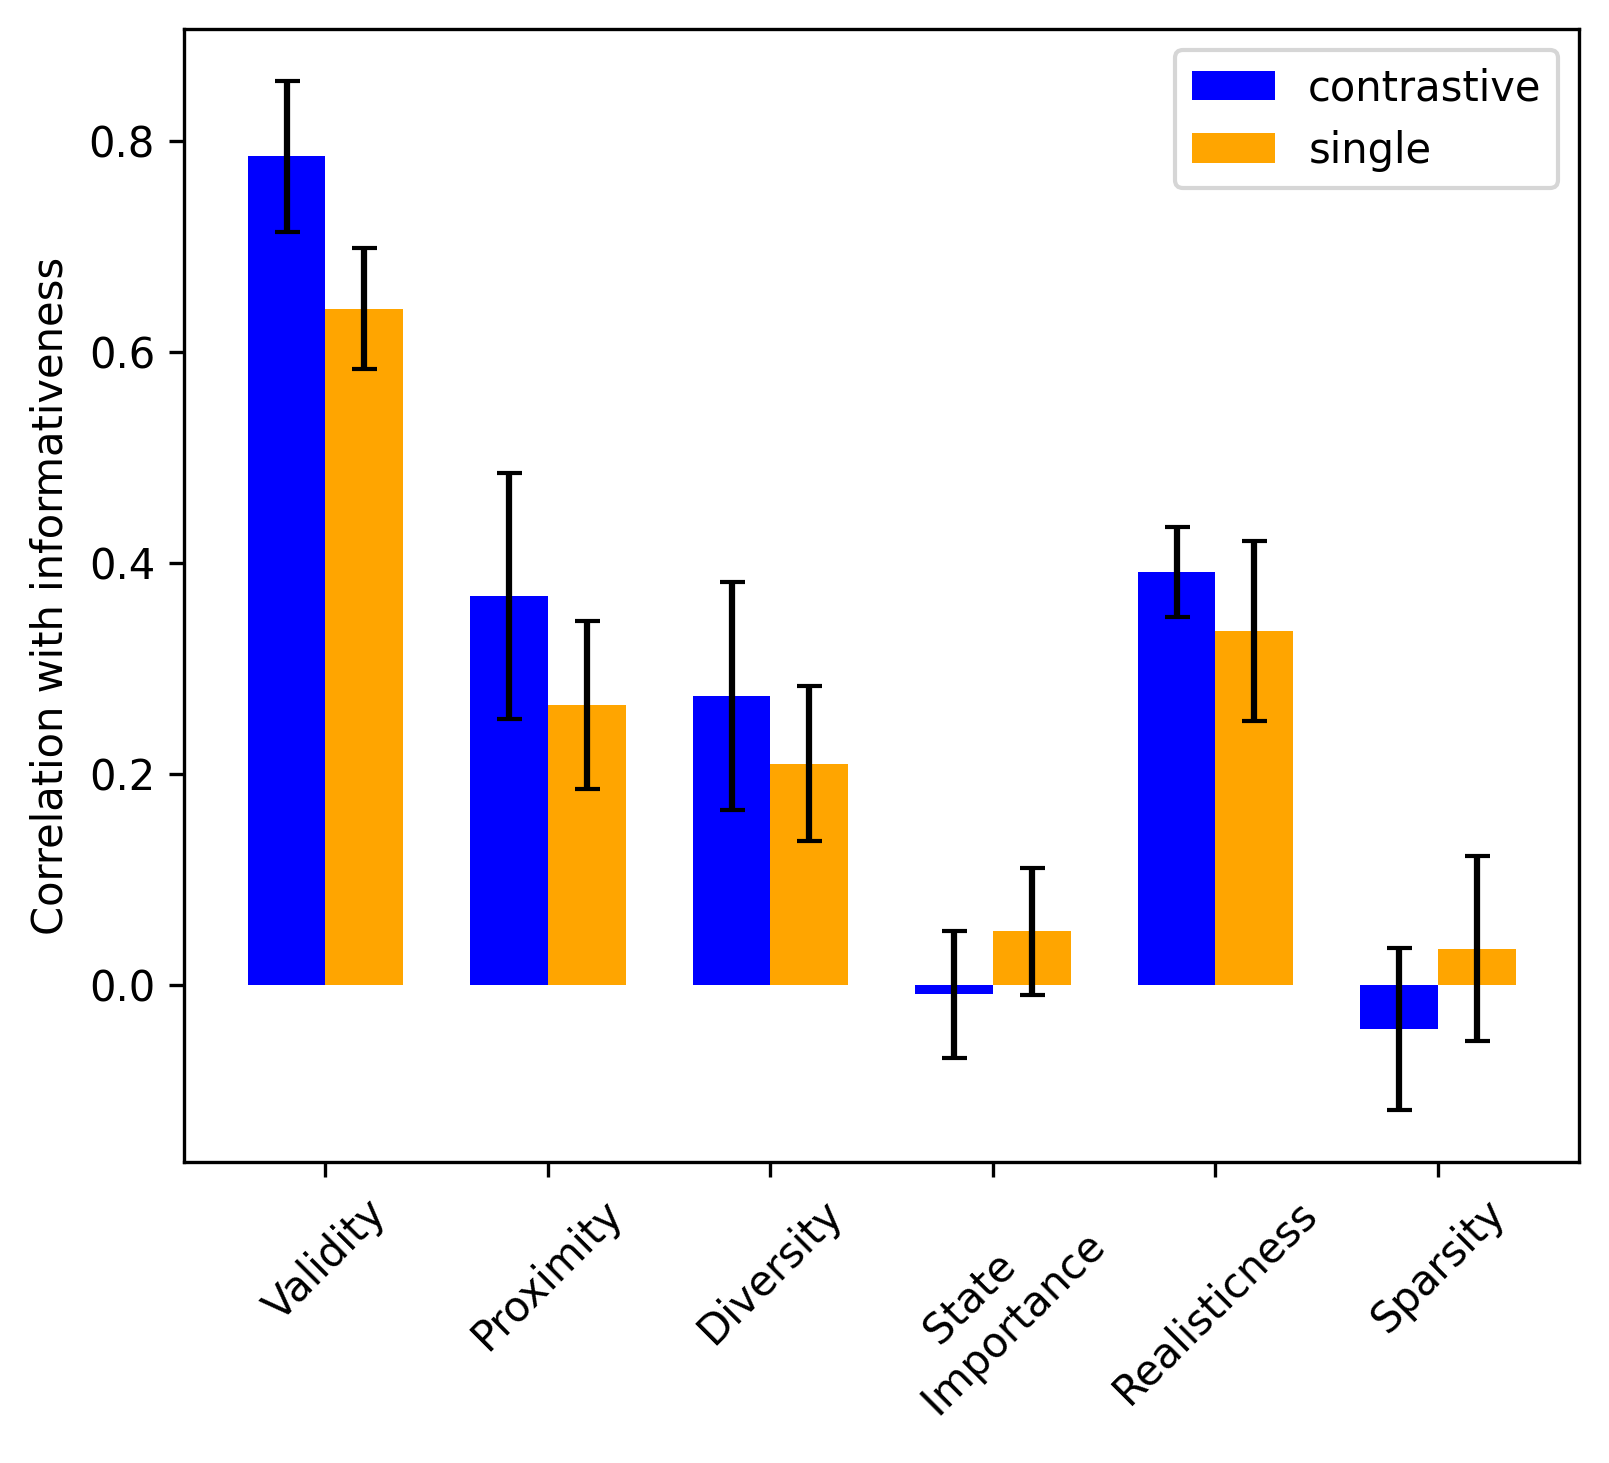

In [48]:
# barplot with spearman correaltions
plt.figure(figsize=(6, 5), dpi=300)
x_labels = ['Validity', 'Proximity', 'Diversity', 'State \n Importance', 'Realisticness', 'Sparsity']
y_con = [vals_corr_spear_con, prox_corr_spear_con, divs_corr_spear_con, crits_corr_spear_con, reals_corr_spear_con, spars_corr_spear_con]
y_sin = [vals_corr_spear_sin, prox_corr_spear_sin, divs_corr_spear_sin, crits_corr_spear_sin, reals_corr_spear_sin, spars_corr_spear_sin]
y_con_std = [vals_corr_spear_cons_std, prox_corr_spear_cons_std, divs_corr_spear_cons_std, crits_corr_spear_cons_std, reals_corr_spear_cons_std, spars_corr_spear_cons_std]
y_sin_std = [vals_corr_spear_sins_std, prox_corr_spear_sins_std, divs_corr_spear_sins_std, crits_corr_spear_sins_std, reals_corr_spear_sins_std, spars_corr_spear_sins_std]

bar_width = 0.35
x = np.arange(len(x_labels))  # the label locations

bar1 = plt.bar(x - bar_width/2, y_con, bar_width, yerr=y_con_std, capsize=3, label='contrastive', color='blue')
bar2 = plt.bar(x + bar_width/2, y_sin, bar_width, yerr=y_sin_std, capsize=3, label='single', color='orange')
# include standard deviation


plt.ylabel('Correlation with informativeness')
plt.xticks(x, x_labels, rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()

### Interpretation

For Contrastive Learning: 
- High weights on Validity and Realisticness have the most influence on the learning
- Diversity seems counterproductive

For Single Learning:
- Criticality, Realisticness, Sparsity and Validity are important
- Diversity is still counterproductive
    - It is unclear whether Diversity in itself is actually bad or in how it interacts with the other criteria

It's slightly surprising that proximity is not that helpful.
For both tasks Validity and Realisticness are important, while State importance and Sparsity are mostly relevant for the single learning.

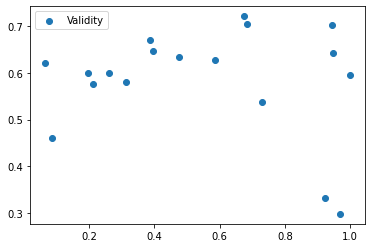

In [25]:
# Scatter plot for data

slope, intercept = np.polyfit(crits, pearson_sin, 1)

plt.scatter(crits, pearson_sin, label='Validity')
# line_x = np.linspace(min(crits), max(crits), 100)  #100 evenly spaced points
# line_y = slope * line_x + intercept
# plt.plot(line_x, line_y, color='blue', label='Fit')  # add line to plot
# plt.scatter(prox, pearson_con, label='Proximity')
plt.legend()
plt.show()

In [26]:
table = [
    ["weight", "Pearson Con", "Pearson Sin"]
]
for weight in weights:
    table.append([weight, np.mean(pearson_correlations_combined_con[weight]), np.mean(pearson_correlations_combined_sin[weight])])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════╤═══════════════╕
│   weight │   Pearson Con │   Pearson Sin │
╞══════════╪═══════════════╪═══════════════╡
│        1 │      0.659909 │      0.622166 │
├──────────┼───────────────┼───────────────┤
│        2 │      0.458641 │      0.263076 │
├──────────┼───────────────┼───────────────┤
│        3 │      0.61785  │      0.585768 │
├──────────┼───────────────┼───────────────┤
│        4 │      0.569777 │      0.482798 │
├──────────┼───────────────┼───────────────┤
│        6 │      0.636178 │      0.616379 │
├──────────┼───────────────┼───────────────┤
│        7 │      0.668591 │      0.617036 │
├──────────┼───────────────┼───────────────┤
│        8 │      0.688942 │      0.658381 │
├──────────┼───────────────┼───────────────┤
│        9 │      0.573211 │      0.570323 │
├──────────┼───────────────┼───────────────┤
│       11 │      0.716883 │      0.683338 │
├──────────┼───────────────┼───────────────┤
│       12 │      0.615149 │      0.533653 │
├─────────